In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import numpy as np

In [30]:
df1 = pd.DataFrame(pd.read_csv('combined.csv'))
df2 = pd.DataFrame(pd.read_csv('metro_kpi.csv'))
df = pd.merge(df1, df2, on='Date', how='outer')
#print(df.isnull().sum())
#df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date                object
Bus                float64
Ridership          float64
Taxi               float64
Uber               float64
ROTP               float64
RailReliability    float64
MetroAccessOTP     float64
EscalatorAvail     float64
ElevatorAvail       object
TotalInjuries      float64
Crime              float64
dtype: object

In [31]:
# Change Elevator Availability from string to float
df['ElevatorAvail'] = df['ElevatorAvail'].str.rstrip('%').astype('float')
df['ElevatorAvail'] = df['ElevatorAvail'] /100
df.head()

,Date,Bus,Ridership,Taxi,Uber,ROTP,RailReliability,MetroAccessOTP,EscalatorAvail,ElevatorAvail,TotalInjuries,Crime
0,2011-01-01,NaN,21082553.0,NaN,NaN,0.879,48241.0,0.901,0.888,0.963,2.08,6.39
1,2011-02-01,NaN,21228262.0,NaN,NaN,0.887,37703.0,0.890,0.866,0.960,1.66,4.68
2,2011-03-01,NaN,26170157.0,NaN,NaN,0.910,50328.0,0.913,0.869,0.969,2.16,3.96
3,2011-04-01,NaN,25656797.0,NaN,NaN,0.909,39302.0,0.912,0.862,0.964,2.21,4.72
4,2011-05-01,NaN,24342603.0,NaN,NaN,0.909,37355.0,0.922,0.825,0.974,1.69,7.32


In [32]:
# Add separate columns for years and months
df['Year'] = ''
df['Month'] = ''
#df['ChDate'] = ''

In [33]:
# Add Year and month values for the future comparison
for ind, row in df.iterrows():
    df.at[ind, 'Year'] = row['Date'][:-6]
    df.at[ind, 'Month'] = row['Date'][5:-3]
    #df.at[ind, 'ChDate'] = row['Year'] + row['Month']
df.head()

,Date,Bus,Ridership,Taxi,Uber,ROTP,RailReliability,MetroAccessOTP,EscalatorAvail,ElevatorAvail,TotalInjuries,Crime,Year,Month
0,2011-01-01,NaN,21082553.0,NaN,NaN,0.879,48241.0,0.901,0.888,0.963,2.08,6.39,2011,01
1,2011-02-01,NaN,21228262.0,NaN,NaN,0.887,37703.0,0.890,0.866,0.960,1.66,4.68,2011,02
2,2011-03-01,NaN,26170157.0,NaN,NaN,0.910,50328.0,0.913,0.869,0.969,2.16,3.96,2011,03
3,2011-04-01,NaN,25656797.0,NaN,NaN,0.909,39302.0,0.912,0.862,0.964,2.21,4.72,2011,04
4,2011-05-01,NaN,24342603.0,NaN,NaN,0.909,37355.0,0.922,0.825,0.974,1.69,7.32,2011,05


In [34]:
df['Year'] = df['Year'].astype('int')
df['Month'] = df['Month'].astype('int')

In [35]:
df.head()

,Date,Bus,Ridership,Taxi,Uber,ROTP,RailReliability,MetroAccessOTP,EscalatorAvail,ElevatorAvail,TotalInjuries,Crime,Year,Month
0,2011-01-01,NaN,21082553.0,NaN,NaN,0.879,48241.0,0.901,0.888,0.963,2.08,6.39,2011,1
1,2011-02-01,NaN,21228262.0,NaN,NaN,0.887,37703.0,0.890,0.866,0.960,1.66,4.68,2011,2
2,2011-03-01,NaN,26170157.0,NaN,NaN,0.910,50328.0,0.913,0.869,0.969,2.16,3.96,2011,3
3,2011-04-01,NaN,25656797.0,NaN,NaN,0.909,39302.0,0.912,0.862,0.964,2.21,4.72,2011,4
4,2011-05-01,NaN,24342603.0,NaN,NaN,0.909,37355.0,0.922,0.825,0.974,1.69,7.32,2011,5


In [36]:
# Create a list of df columns name
features = [column for column in df]

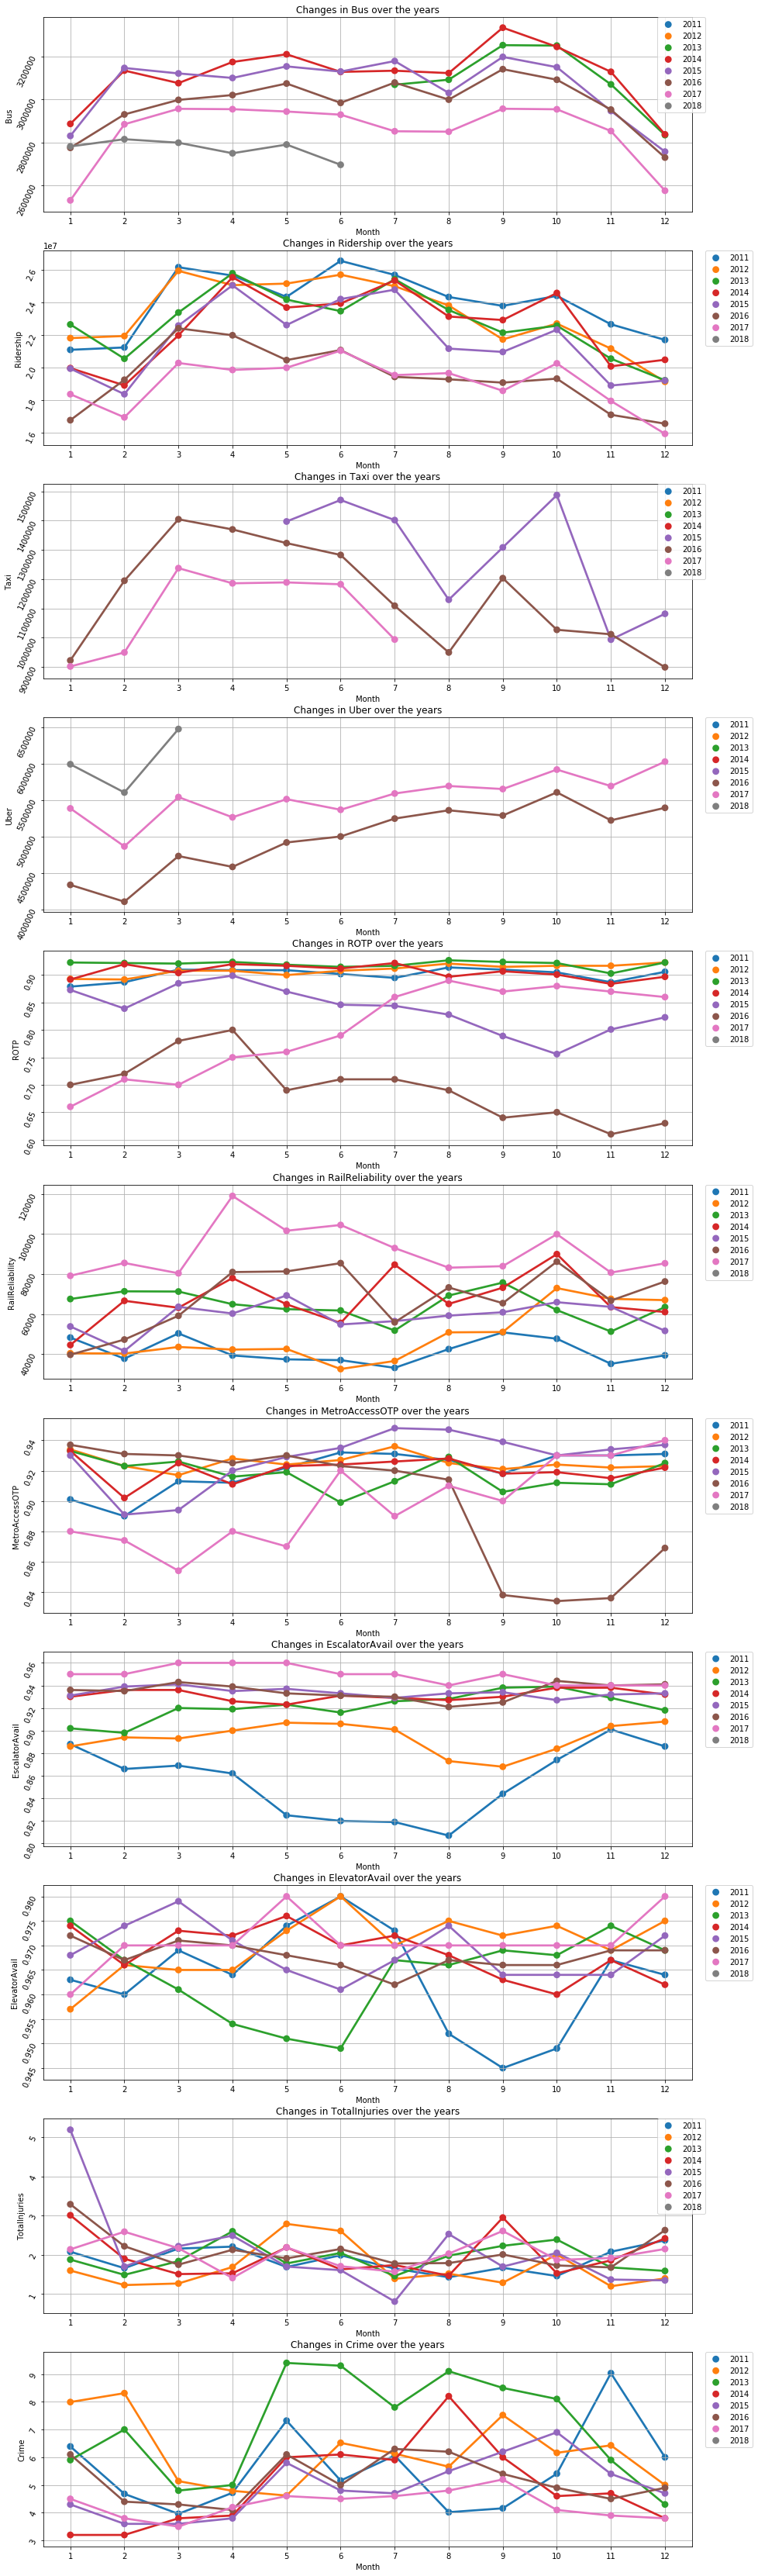

In [37]:
# Visualize a relationship between months of a year and the features
plt.figure(figsize=(15,60))
x = 1
for feature in features:
    if (feature != 'Date') & (feature != 'Year') & (feature != 'Month') & (feature != 'ChDate'):
        plt.subplot(11,1,x)
        sns.pointplot(x=df['Month'], y=df[feature], hue=df['Year'])
        plt.title(f'Changes in {feature} over the years')
        plt.legend(bbox_to_anchor=(1.02, 1), loc=0, borderaxespad=0.)
        plt.yticks(rotation=65)
        plt.grid(True)
        x += 1

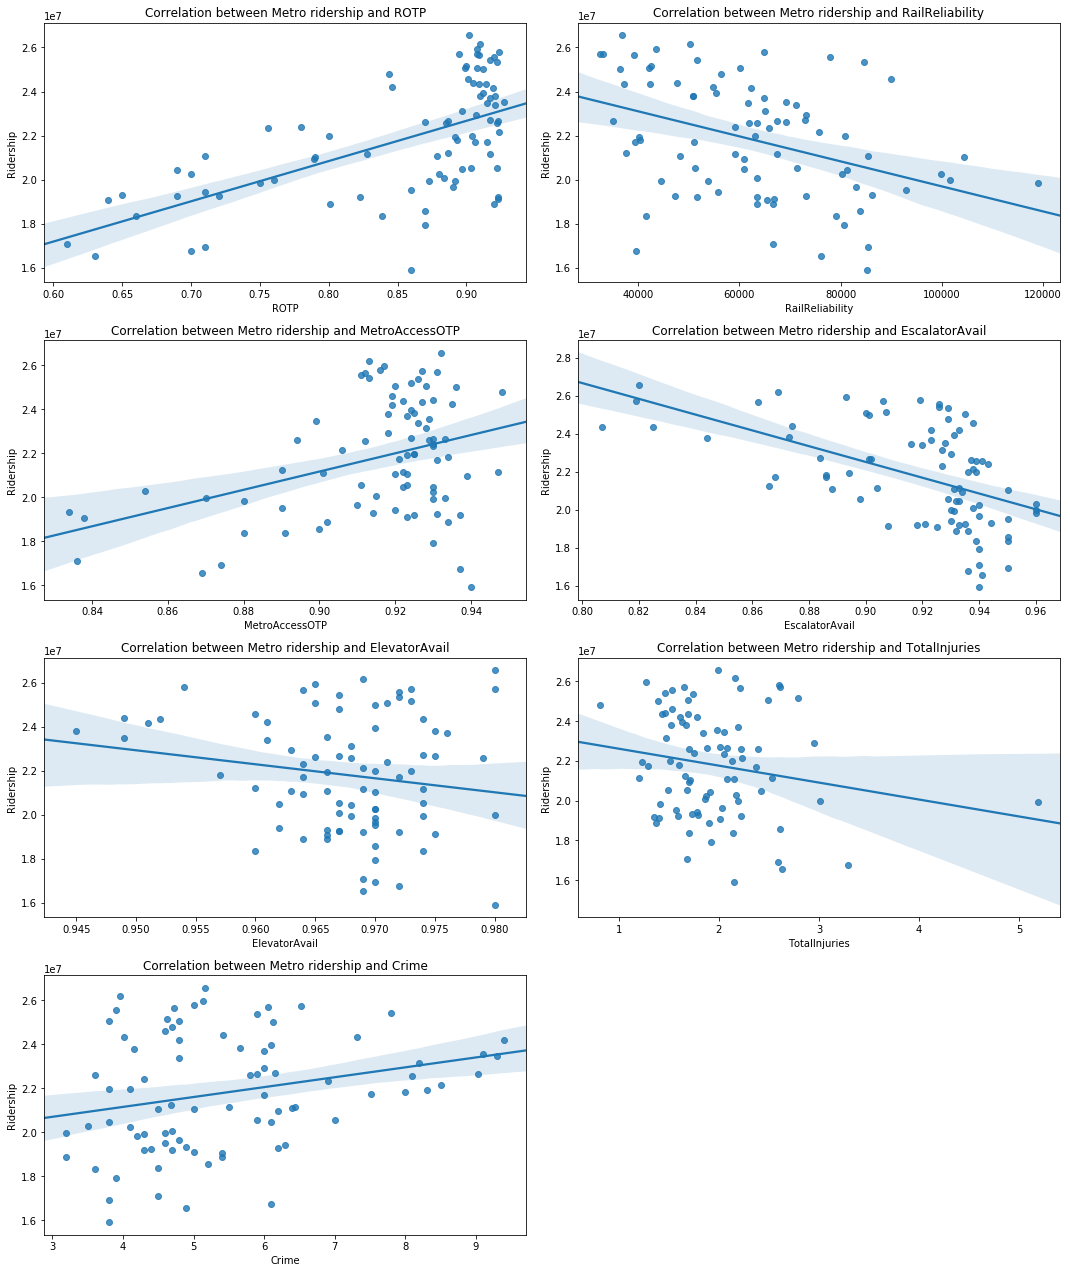

In [38]:
# Visualize a correlation between Metro ridership and KPIs
plt.figure(figsize=(15,35))
x = 1
for feature in features:
    if (feature != 'Date') & (feature != 'Bus') & (feature != 'Ridership') & (feature != 'Taxi') & (feature != 'Uber') & (feature != 'Year') & (feature != 'Month'):
        plt.subplot(8,2,x)
        sns.regplot(data=df, x=df[feature], y=df['Ridership'])
        plt.title(f'Correlation between Metro ridership and {feature}')
        x += 1
plt.tight_layout()

In [39]:
# Create a mask for all NaN values
masks = []
masks.extend((~np.isnan(df['Bus']), ~np.isnan(df['Ridership']), ~np.isnan(df['Taxi']), ~np.isnan(df['Uber']),
             ~np.isnan(df['ROTP']), ~np.isnan(df['RailReliability']), ~np.isnan(df['MetroAccessOTP']),
             ~np.isnan(df['EscalatorAvail']), ~np.isnan(df['ElevatorAvail']), ~np.isnan(df['TotalInjuries']),
             ~np.isnan(df['Crime'])))
ttt = masks[4] & masks[1]

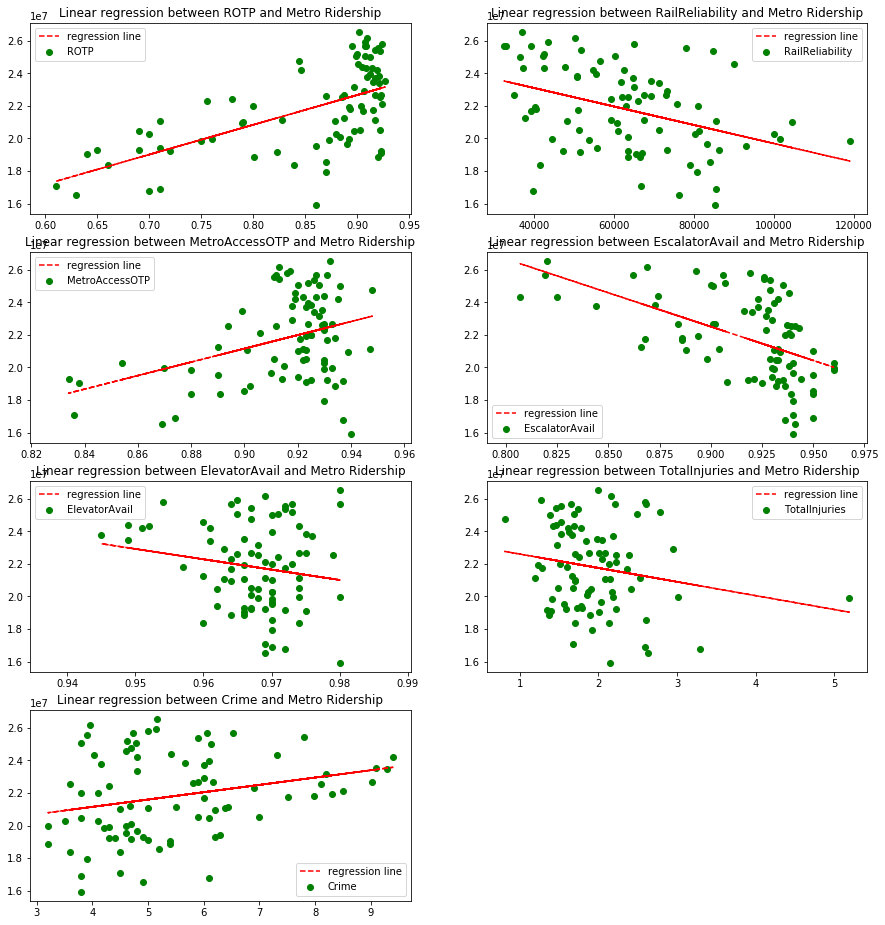

In [40]:
# Collect Ridership/KPI coefficients and put them in a dictionary
reg_data = {}
plt.figure(figsize=(15,33))
c = 1
for x in range(len(features)):
    if (features[x] != 'Date') & (features[x] != 'Bus') & (features[x] != 'Ridership') & (features[x] != 'Taxi') & (features[x] != 'Uber') & (features[x] != 'Year') & (features[x] != 'Month'):
        
        reg_data[features[x]] = stats.linregress(df[features[x]][masks[x-1] & masks[1]],
                                                 df['Ridership'][masks[x-1] & masks[1]])
        fit = (reg_data[features[x]][0] * df[features[x]]) + reg_data[features[x]][1]
        
        # Check if coefficients are correct
        plt.subplot(8,2,c)
        plt.scatter(df[features[x]], df['Ridership'], label=(f'{features[x]}'), c='g')
        plt.plot(df[features[x]], fit, 'r--', label='regression line')
        plt.title(f'Linear regression between {features[x]} and Metro Ridership')
        plt.legend()
        c +=1
        

In [41]:
# Create DF to keep all regression coefficients
coef_df = pd.DataFrame(reg_data).transpose()
coef_df.columns = ['Slope', 'Intercept', 'R', 'P', 'StdError']
coef_df['Coef_determ'] = coef_df['R']**2
coef_df.to_csv('data_acquisition/combined/linear_regression_coeff_KPI.csv')

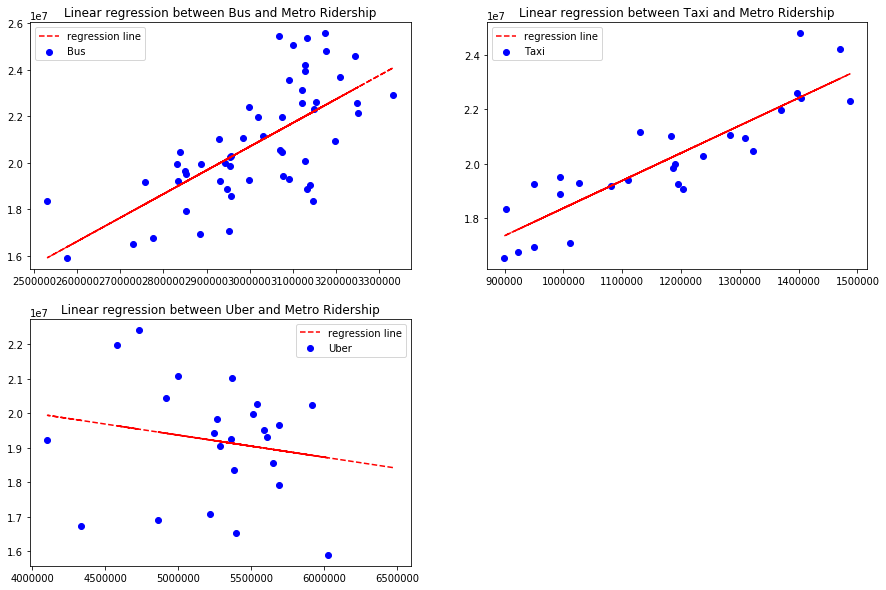

In [42]:
transp_data = {}
plt.figure(figsize=(15,10))
c = 1
for x in range(len(features)):
    if (features[x] == 'Bus') | (features[x] == 'Taxi') | (features[x] == 'Uber'):
        
        transp_data[features[x]] = stats.linregress(df[features[x]][masks[x-1] & masks[1]],
                                                 df['Ridership'][masks[x-1] & masks[1]])
        fit = (transp_data[features[x]][0] * df[features[x]]) + transp_data[features[x]][1]
        # Plot correlation
        plt.subplot(2,2,c)
        plt.scatter(df[features[x]], df['Ridership'], label=(f'{features[x]}'), c='b')
        plt.plot(df[features[x]], fit, 'r--', label='regression line')
        plt.title(f'Linear regression between {features[x]} and Metro Ridership')
        plt.legend()
        c +=1


In [49]:
coef_transp_df = pd.DataFrame(transp_data).transpose()
coef_transp_df.columns = ['Slope', 'Intercept', 'R', 'P', 'StdError']
coef_transp_df['Coef_determ'] = coef_transp_df['R']**2
coef_transp_df.to_csv('data_acquisition/combined/linear_regression_coeff_Transport.csv')
coef_transp_df

,Slope,Intercept,R,P,StdError,Coef_determ
Bus,10.153866,-9.772630e+06,0.685002,1.109373e-08,1.497585,0.469228
Taxi,10.124647,8.242658e+06,0.883628,1.019787e-09,1.072910,0.780798
Uber,-0.639144,2.256164e+07,-0.179567,4.011378e-01,0.746523,0.032244


In [44]:
import statsmodels.formula.api as smf
model = smf.ols(formula='Ridership ~ ROTP + RailReliability', data=df).fit()
model.params

Intercept          1.007828e+07
ROTP               1.606127e+07
RailReliability   -3.133487e+01
dtype: float64

In [45]:
from mpl_toolkits.mplot3d import Axes3D
x_surf, y_surf = np.meshgrid(np.linspace(df.ROTP.min(), df.ROTP.max(), 100),np.linspace(df.RailReliability.min(),
                                                                                        df.RailReliability.max(), 100))
onlyX = pd.DataFrame({'ROTP': x_surf.ravel(), 'RailReliability': y_surf.ravel()})
fittedY=model.predict(exog=onlyX)

/Users/sonik/anaconda3/envs/pythondata/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


Text(0.5,0,'Ridership')

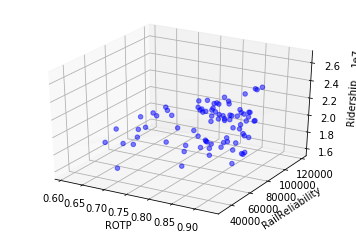

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['ROTP'],df['RailReliability'],df['Ridership'],c='blue', marker='o', alpha=0.5)
ax.plot_surface(x_surf,y_surf,fittedY.reshape(x_surf.shape), color='None', alpha=0.01)
ax.set_xlabel('ROTP')
ax.set_ylabel('RailReliability')
ax.set_zlabel('Ridership')


In [47]:
X_new= [[0.90,40],[0.85,55],[0.70,40],[0.75,60]]
df_new= pd.DataFrame(X_new,columns=['ROTP','RailReliability'])
predict = model.predict(df_new)
predict

0    2.453217e+07
1    2.372864e+07
2    2.131992e+07
3    2.212235e+07
dtype: float64